<a href="https://colab.research.google.com/github/ParishaKB/ANPR/blob/main/anpr_image_flask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
import cv2

# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('/content/contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        #detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        #checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            #extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

#             Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) #List that stores the character's binary image (unsorted)
            
    #Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    #arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [ ]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

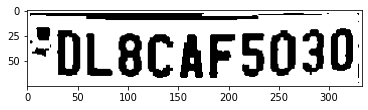

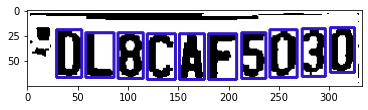

In [ ]:
img = cv2.imread('/content/car_plate.png')
char = segment_characters(img)

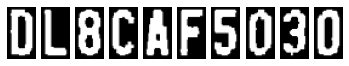

In [ ]:
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')

### Model for characters

In [ ]:
import tensorflow as tf
#tf.enable_eager_execution()

In [ ]:
!unzip data.zip

Archive:  data.zip
replace __MACOSX/._data? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/._data         
replace __MACOSX/data/._train? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: __MACOSX/data/._train   
  inflating: __MACOSX/data/._val     
  inflating: __MACOSX/data/train/._class_M  
  inflating: __MACOSX/data/train/._class_J  
  inflating: __MACOSX/data/train/._class_C  
  inflating: __MACOSX/data/train/._class_D  
  inflating: __MACOSX/data/train/._class_V  
  inflating: __MACOSX/data/train/._class_Q  
  inflating: __MACOSX/data/train/._class_4  
  inflating: __MACOSX/data/train/._class_X  
  inflating: __MACOSX/data/train/._class_3  
  inflating: __MACOSX/data/train/._class_E  
  inflating: __MACOSX/data/train/._class_B  
  inflating: __MACOSX/data/train/._class_K  
  inflating: __MACOSX/data/train/._class_L  
  inflating: __MACOSX/data/train/._class_2  
  inflating: __MACOSX/data/train/._class_Y  
  inflating: __MACOSX/data/train/._class_5  
  inflating

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
train_generator = train_datagen.flow_from_directory(
        '/content/data/train',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
        '/content/data/val',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28        batch_size=1,
        class_mode='categorical')

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
from tensorflow.keras import optimizers

In [ ]:
model = Sequential()
model.add(Conv2D(32, (24,24), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.00001), metrics=['accuracy'])

In [ ]:
History = model.fit(train_generator,validation_data = validation_generator,epochs = 80)

Epoch 1/80
864/864 [==============================] - 5s 4ms/step - loss: 3.5977 - accuracy: 0.0403 - val_loss: 3.4045 - val_accuracy: 0.1898
Epoch 2/80
864/864 [==============================] - 3s 3ms/step - loss: 3.3440 - accuracy: 0.1458 - val_loss: 3.0061 - val_accuracy: 0.3287
Epoch 3/80
864/864 [==============================] - 3s 3ms/step - loss: 2.9136 - accuracy: 0.2848 - val_loss: 2.5100 - val_accuracy: 0.4306
Epoch 4/80
864/864 [==============================] - 3s 3ms/step - loss: 2.4023 - accuracy: 0.3861 - val_loss: 2.0448 - val_accuracy: 0.6204
Epoch 5/80
864/864 [==============================] - 3s 3ms/step - loss: 1.9457 - accuracy: 0.5111 - val_loss: 1.7128 - val_accuracy: 0.6759
Epoch 6/80
864/864 [==============================] - 3s 3ms/step - loss: 1.6260 - accuracy: 0.5762 - val_loss: 1.4562 - val_accuracy: 0.6806
Epoch 7/80
864/864 [==============================] - 3s 3ms/step - loss: 1.3556 - accuracy: 0.6368 - val_loss: 1.2196 - val_accuracy: 0.7407
Epoch 

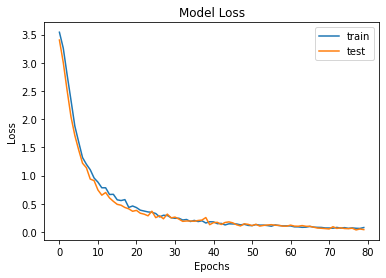

In [ ]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

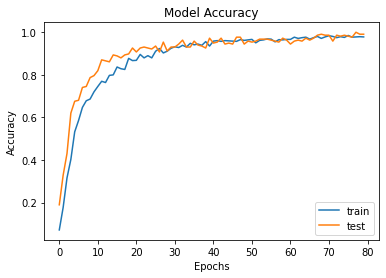

In [ ]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [ ]:
def fix_dimension(img): 
  new_img = np.zeros((28,28,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img
  
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28))
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        y_ = model.predict_classes(img)[0] #predicting the class
        character = dic[y_] #
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number

print(show_results())

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0L8CAF5030


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


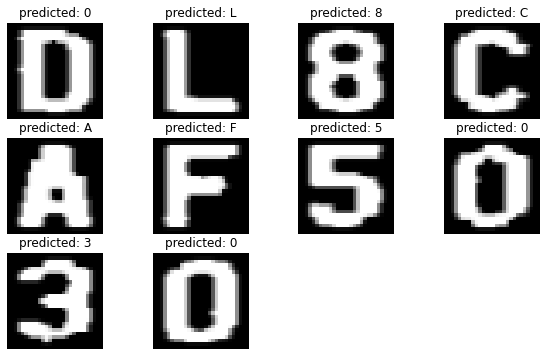

In [ ]:
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28))
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results()[i]}')
    plt.axis('off')
plt.show()

Saving the Model

In [ ]:
model.save('BestModel.h5', save_format='h5')

#Flask Deployment

##Installing Flask

In [ ]:
!pip install flask gevent requests pillow

a
a
a
     |████████████████████████████████| 5.9MB 9.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached https://files.pythonhosted.org/packages/80/d0/532e160c777b42f6f393f9de8c88abb8af6c892037c55e4d3a8a211324dd/greenlet-0.4.17-cp36-cp36m-manylinux1_x86_64.whl
     |████████████████████████████████| 245kB 56.4MB/s 
  Created wheel for gevent: filename=gevent-20.12.1-cp36-cp36m-linux_x86_64.whl size=4514421 sha256=f1042e00b354f09c12edc317ddd44b1cdeb45505ede599b3547c77563bd37c3e
  Stored in directory: /root/.cache/pip/wheels/ff/50/b8/b5e0c7b64d587ee7fd0c1bb9aac40b953fdb2da4e49b7b99db
Successfully built gevent


In [ ]:
!pip install flask-ngrok

##Libraries

In [ ]:
from flask_ngrok import run_with_ngrok
from flask import Flask, render_template, request

##Webpage Design

Creating a Design

In [ ]:
a = '''

<!doctype html>
<html lang="en">

<head>

</head> 

<body>
 
<h3>Number Plate Recognition Server</h3>
       
<form action="" method=post enctype=multipart/form-data>
<input type=file name=file>
<input type=submit value=Upload>
</form>

{{label}}  
     
</body>

</html>
'''

Saving the Design

In [ ]:
!mkdir '/content/templates'
!mkdir '/content/uploads'

Html_file = open("/content/templates/index.html", "w")
Html_file.write(a)
Html_file.close()

##Defining Fuctions for App

Loading CNN Model

In [ ]:
def load_mymodel():
    global mymodel
    mymodel = load_model('BestModel.h5')

Predicting the Number

In [ ]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
def predictions(img):
    img = image.load_img(img, target_size=(28,28), color_mode="grayscale")
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    ans = mymodel.predict_classes(img)
    return ans

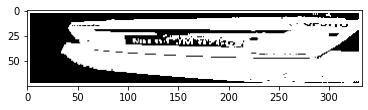

IndexError: ignored

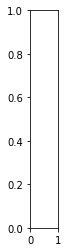

In [ ]:
img = cv2.imread('/content/test.png')
char = segment_characters(img)
for i in range(9):
    plt.subplot(1, 10, i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')

##Deploying the Model

In [ ]:
app = Flask(__name__)
import os
run_with_ngrok(app)
app.config['UPLOADS'] = 'uploads'
from keras.models import load_model
@app.route('/')
def home():
    return render_template('index.html')

@app.route('/', methods=['POST'])
def upload_files():
    file = request.files['file']
    filepath = os.path.join(app.config['UPLOADS'], file.filename)
    file.save(filepath)
    output = predictions(filepath)
    return render_template('index.html', label=output)

if __name__=='__main__':
    load_mymodel()
    app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://ffc368863cef.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [27/Dec/2020 14:37:48] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [27/Dec/2020 14:37:49] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [27/Dec/2020 14:38:12] "POST / HTTP/1.1" 400 -
[2020-12-27 14:40:21,970] ERROR in app: Exception on / [POST]
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/usr/local/lib/python3.6/dist-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/usr/local/lib/python3.6/dist-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/usr/local/lib/python3.6/dist-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/usr/local/lib/python3.6/dist-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/usr/local/lib/python3.6/dist-packages/flask/app.py", line 1936, in d